In [2]:
import pandas as pd
from ast import literal_eval
import numpy as np

import pandas as pd
pd.options.mode.chained_assignment = None

import seaborn as sns
import matplotlib.pyplot as plt

from typing import List
from IPython.core.display import HTML


In [3]:
def filter_icrc(one_tweet):
    """
    function to keep ICRC related tweets
    """
    icrc_kw = ['icrc', 'cicr']
    return any([one_icrc_kw in one_word_tweet.lower() for one_word_tweet in one_tweet.split(' ') for one_icrc_kw in icrc_kw])

In [5]:
en_sentiments = pd.read_csv('generated_data/sentiments_numbers_en.csv', compression='gzip')
print(f'For the English language, we have a total of {en_sentiments.shape[0]} tweets')

fr_sentiments = pd.read_csv('generated_data/sentiments_numbers_fr.csv', compression='gzip')
print(f'For the French language, we have a total of {fr_sentiments.shape[0]} tweets')

ar_sentiments = pd.read_csv('generated_data/sentiments_numbers_ar.csv', compression='gzip')
print(f'For the Arabic language, we have a total of {ar_sentiments.shape[0]} tweets')


For the English language, we have a total of 194024 tweets
For the French language, we have a total of 18625 tweets
For the Arabic language, we have a total of 21098 tweets


* Mean sentiments for anger and offensiveness ofor French and English

In [6]:

all_dict = {}
anger_dict = {
'fr' : np.round(fr_sentiments.anger.mean(), 2),
'en' : np.round(en_sentiments.anger.mean(), 2),
}
offensive_tot = {
'fr' : np.round(en_sentiments.offensive.mean(), 2),
'en' : np.round(en_sentiments.offensive.mean(), 2),
}


all_dict['anger'] = anger_dict
all_dict['offensive'] = offensive_tot

pd.DataFrame.from_dict(all_dict, orient='index')

,fr,en
anger,0.20,0.30
offensive,0.14,0.14


* Filter out ICRC tweets

In [7]:
icrc_en = en_sentiments[en_sentiments.tweet.apply(filter_icrc)]
icrc_fr = fr_sentiments[fr_sentiments.tweet.apply(filter_icrc)]
icrc_ar = ar_sentiments[ar_sentiments.tweet.apply(filter_icrc)]

print(f'The number of ICRC tweets in english are: {len(icrc_en)}, out of a total of {en_sentiments.shape[0]} english tweets.')
print(f'The number of ICRC tweets in french are: {len(icrc_fr)}, out of a total of {fr_sentiments.shape[0]} french tweets.')
print(f'The number of ICRC tweets in arabic are: {len(icrc_ar)}, out of a total of {ar_sentiments.shape[0]} arabic tweets.')

The number of ICRC tweets in english are: 39942, out of a total of 194024 english tweets.
The number of ICRC tweets in french are: 3889, out of a total of 18625 french tweets.
The number of ICRC tweets in arabic are: 1410, out of a total of 21098 arabic tweets.


In [8]:
en_hdbscan = pd.read_csv('generated_data_decompressed/partitions_en_hdbscan_final.csv')
print(f'For the English language, we have {en_hdbscan.shape[0]} filtered tweets')

fr_hdbscan = pd.read_csv('generated_data_decompressed/partitions_fr_hdbscan_final.csv')
print(f'For the French language, we have {fr_hdbscan.shape[0]} filtered tweets')

ar_hdbscan = pd.read_csv('generated_data_decompressed/partitions_ar_hdbscan_final.csv')
print(f'For the Arabic language, we have {ar_hdbscan.shape[0]} filtered tweets')

For the English language, we have 9701 filtered tweets
For the French language, we have 931 filtered tweets
For the Arabic language, we have 1054 filtered tweets


* DataFrame for the total number of tweets

In [9]:
all_dict = {}
tot_dict = {
'fr' : fr_sentiments.shape[0],
'en' : en_sentiments.shape[0],
'ar' : ar_sentiments.shape[0]
}
icrc_tot = {
'fr' : fr_sentiments.tweet.apply(filter_icrc).sum(),
'en' : en_sentiments.tweet.apply(filter_icrc).sum(),
'ar' : ar_sentiments.tweet.apply(filter_icrc).sum()
}
icrc_filter = {
'fr' : fr_hdbscan.tweet.apply(filter_icrc).sum(),
'en' : en_hdbscan.tweet.apply(filter_icrc).sum(),
'ar' : ar_hdbscan.tweet.apply(filter_icrc).sum()
}

all_dict['all_tweets'] = tot_dict
all_dict['all_icrc'] = icrc_tot
all_dict['icrc_filtered'] = icrc_filter

pd.DataFrame.from_dict(all_dict, orient='index')

,fr,en,ar
all_tweets,18625,194024,21098
all_icrc,3889,39942,1410
icrc_filtered,519,2919,177


* Number of clusters and unclustered tweets for each language

In [10]:
lang_to_df = {
    'en': en_hdbscan,
    'fr': fr_hdbscan,
    'ar': ar_hdbscan
}

for lang, df in lang_to_df.items():
    print(f'----------------- for the {lang} language -----------------') 
    print(f'The total number of unclustered entries is: {df.partition.max() + 1}')
    print(f'The percentage of non clustered entries is: {np.round((df.partition==-1).sum() / df.shape[0], 2) * 100}%')

----------------- for the en language -----------------
The total number of unclustered entries is: 275
The percentage of non clustered entries is: 45.0%
----------------- for the fr language -----------------
The total number of unclustered entries is: 29
The percentage of non clustered entries is: 18.0%
----------------- for the ar language -----------------
The total number of unclustered entries is: 32
The percentage of non clustered entries is: 30.0%


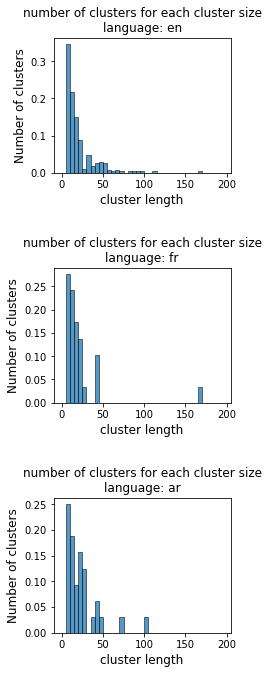

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(4, 10), facecolor='white')

i = 0
for language_tmp, df in lang_to_df.items():
    clusters = df[['partition', 'cluster_size', 'topic']].drop_duplicates().iloc[1:]
    sns.histplot(clusters.cluster_size, bins=[i*5 for i in range (40)], ax=axes[i], stat='probability')
    plt.ylabel('number of clusters')
    axes[i].set_title(f'number of clusters for each cluster size\nlanguage: {language_tmp}')


    #plt.xlabel('f1 score', fontsize=14)
    axes[i].set_xlabel('cluster length', size=12)
    axes[i].set_ylabel('Number of clusters', size=12)

    i += 1

fig.tight_layout(pad=3.0)

#plt.suptitle('Histograms of clusters lenghths for English, French and Arabic\n', fontsize=16)

plt.savefig('photos/hists_cluster_lengths.png', bbox_inches="tight")

In [12]:
def get_bool_one_kw_one_row(topics_list, needed_topic: str):
    if type(topics_list) is str:
        return needed_topic in  topics_list
    else:
        if len(topics_list)==0:
            return False
        else:
            return any([needed_topic in item for item in topics_list])

def get_topics_present_in_kw(df: pd.DataFrame, needed_topic: str):
    return df.loc[df.topic.apply(lambda x: get_bool_one_kw_one_row(x, needed_topic)), 'partition'].tolist()

* Get overview of topics and their repetitiveness in clusters:

In [13]:
# topics that possibly work for THIS dataset
clusters = en_hdbscan[['partition', 'cluster_size', 'topic']].drop_duplicates().iloc[1:]

tested_topics = ['gay', 'blood', 'homophob', 'donat', 'steal', 'hypocri']

test_dict = {}
for one_tested_topic in tested_topics:
    dict_one_topic = {}
    topics = get_topics_present_in_kw (clusters, one_tested_topic)
    dict_one_topic['topics_list'] = topics
    dict_one_topic['n_topics'] = len(topics)
    
    test_dict[one_tested_topic] = dict_one_topic

kept_df = pd.DataFrame.from_dict(test_dict, orient='index')
kept_df

,topics_list,n_topics
gay,"[74, 71, 64, 67, 72, 73, 63, 57, 75]",9
blood,"[50, 48, 74, 71, 55, 67, 49, 174, 44, 65, 51, ...",17
homophob,"[74, 71, 64, 72, 63, 53]",6
donat,"[50, 214, 48, 74, 18, 109, 169, 87, 38, 266, 2...",43
steal,"[170, 273]",2
hypocri,"[39, 155]",2


* Example of clusters return for the French language

In [14]:
fr_clusters = fr_hdbscan[['partition', 'cluster_size', 'topic']].drop_duplicates()
display(HTML(fr_clusters.head(20).to_html()))

,partition,cluster_size,topic
0,0,307,"['lotan', 'cicr', 'zone', 'traîtres', 'actions', 'toutes', 'russie', 'miné', 'conventions']"
307,-1,166,[]
473,6,44,"['droit', 'cicr', 'international', 'croixrouge', 'parties', 'rouge', 'humanitaire', 'croix', 'violence', 'cest']"
517,19,42,"['croixrouge', 'rouge', 'humanitaire', 'croix', 'ukraine', 'russie', 'russes', 'russe']"
559,2,41,"['cicr', 'cyberattaque', 'personnes', 'données', 'dune', 'rouge', 'hackers', 'croix', 'victime']"
600,7,27,"['cicr', 'guerre', 'chose', 'conventions', 'rend', 'parle', 'russie', 'tous', 'russes', 'cest']"
627,1,22,"['lukraine', 'enfants', 'rouge', 'infirmier', 'croissant', 'croix', 'camp', 'russes']"
649,5,21,"['vax', 'croixrouge', 'plasma', 'rouge', 'sang', 'vaccinés', 'comme', 'croix', 'vaccination']"
670,8,21,"['guerre', 'règles', 'faire', 'fait', 'crime', 'crimes', 'sans', 'tuer']"
691,17,20,"['vont', 'hypocrite', 'bien', 'politique', 'hypocrites', 'peur', 'jdis', 'seul', 'cette', 'cest']"


* Example of visualization for one luster number

In [15]:
display(HTML(fr_hdbscan[fr_hdbscan.partition==17][['tweet_id', 'tweet']].to_html()))

,tweet_id,tweet
691,1498200056968712192,@CICR_fr C'est le monde des hypocrites ! http
692,1498959607330488320,@GautierCapucon @France2tv @franceinter @Nagui @Leilakan @nationaldefce @CroixRouge Les habituels idiots utiles de la culture qui bien souvent n’en n’ont pas beaucoup
693,1498692762354561024,@GautierCapucon @France2tv @franceinter @Nagui @Leilakan @nationaldefce @CroixRouge Le ballet des hypocrites !
694,1501325330153361408,@NadineGirault @MRIF_Quebec @MdMCanada @CroixRouge_Qc Si vous étiez aussi proactif envers les enjeux d'ici... hypocrite.
695,1485244274581151744,"Ya des mecs qui sont montés dans le tram et qui ont commencé à faire leur cinéma en mode ils vont defoncer un gars et lui ont fait des menaces du style"" si tu reviens a campus croix rouge t'es mort"". FSQJFSQJKSK ils faisaient meme pas un peu peur en +,n!ggas you were pathetic asf"
696,1498198835050557440,"@CICR_fr Hypocrite !!!\nQuand les 🇺🇸 et 🇮🇱 s'en donnent à cœur joie sur les civils, vous devenez subitement 🙈🙉🙊"
697,1497407327565238272,@JustinTrudeau @CroixRouge_Qc J’dis ca j’dis rien 🙃 … bon finalement j’pas capable de rien dire 😬🙄 .. Tu est un hypocrite Trudo http
698,1502217014039171072,@Redkiraz Tous les clowns assassins vont quitter leurs fonctions les uns après les autres. Ils ont bien trop peur des suites judiciaires qui pourraient les attendre. \nJe ne serais pas étonné que Berset quitte bientôt lui aussi son poste...(Croix-Rouge?)
699,1502952062996332544,@nationaldefce @franceinter @CroixRouge @Maisondelaradio @ChoeurRF @MaitriseRF @france2 Un concert pour eux ?\nArtistes hypocrites 🖕 http
700,1497654866067476480,@PierrePoilievre @CUFCanada @CroixRouge_Qc Les camioneurs n’ont pas eu autant d’éloges hypocrite


* Filter ICRC tweets after filtering potentially relevant tweets

In [6]:
filtered_icrc_en = en_hdbscan[en_hdbscan.tweet.apply(filter_icrc)]
filtered_icrc_fr = fr_hdbscan[fr_hdbscan.tweet.apply(filter_icrc)]
filtered_icrc_ar = ar_hdbscan[ar_hdbscan.tweet.apply(filter_icrc)]

* Create clusters DataFrames for Arabic, French and English after manually going through and labeling clusters

In [16]:
clusters_ar = {
    13: {
        'Troll Attack': True,
        'Disinformation': True,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': False,
        'topic': 'ICRC not doing enough in Yemen'
    },
    0: {
        'Troll Attack': False,
        'Disinformation': True,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': False,
        'topic': '....'
    },
    16: {
        'Troll Attack': True,
        'Disinformation': True,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': False,
        'topic': 'General Attacks'
    },
    1: {
        'Troll Attack': False,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': True,
        'topic': 'Difference of treatement between Syrian and Ukrainian refugees'
    },
    18: {
        'Troll Attack': False,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': True,
        'topic': 'Not making political statement about the wars in Arab countries (compared to statements about Ukraine war)'
    }
}

ar_df = pd.DataFrame.from_dict(clusters_ar, orient='index')
ar_df['cluster_number'] = ar_df.index
ar_df = ar_df[ar_df.columns[::-1]]
ar_df

,cluster_number,topic,Geopolitics,"True, but of interest",Misleading,Disinformation,Troll Attack
13,13,ICRC not doing enough in Yemen,False,False,False,True,True
0,0,....,False,False,False,True,False
16,16,General Attacks,False,False,False,True,True
1,1,Difference of treatement between Syrian and Uk...,True,False,False,False,False
18,18,Not making political statement about the wars ...,True,False,False,False,False


In [17]:
clusters_fr = {
    2: {
        'Troll Attack': False,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': True,
        'Geopolitics': False,
        'topic': 'Cyberattack the ICRC was victim of'
    },
    17: {
        'Troll Attack': True,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': False,
        'topic':'......'
    },
    0: {
        'Troll Attack': True,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': False,
        'topic':'......'
    },
    24: {
        'Troll Attack': False,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': True,
        'Geopolitics': False,
        'topic': 'Non neutrality: more virulent agianst Russia than Israel'
    },
    28: {
        'Troll Attack': False,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': True,
        'topic': 'Difference of treatement between Syrian and Ukrainian refugees'
    },
    23: {
        'Troll Attack': False,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': True,
        'topic': 'Difference of treatement between Ukraine and Palestine'
    }
}

fr_df = pd.DataFrame.from_dict(clusters_fr, orient='index')
fr_df['cluster_number'] = fr_df.index
fr_df = fr_df[fr_df.columns[::-1]]
fr_df

,cluster_number,topic,Geopolitics,"True, but of interest",Misleading,Disinformation,Troll Attack
2,2,Cyberattack the ICRC was victim of,False,True,False,False,False
17,17,......,False,False,False,False,True
0,0,......,False,False,False,False,True
24,24,Non neutrality: more virulent agianst Russia t...,False,True,False,False,False
28,28,Difference of treatement between Syrian and Uk...,True,False,False,False,False
23,23,Difference of treatement between Ukraine and P...,True,False,False,False,False


In [18]:
clusters_en = {
    214: {
        'Troll Attack': True,
        'Disinformation': True,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': False,
        'topic': 'Crisitism of money usage'
    },
    132: {
        'Troll Attack': False,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': True,
        'topic': 'Difference of treatement between Ukraine and other Arab countries'
    },
    82: {
        'Troll Attack': False,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': False,
        'topic': 'Not doing enough in Ethiopia'
    },
    102: {
        'Troll Attack': False,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': True,
        'topic': 'Melania Trump related donation for Ukraine'
    },
    45: {
        'Troll Attack': False,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': True,
        'topic': 'Melania Trump related donation for Ukraine'
    },
    35: {
        'Troll Attack': False,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': True,
        'topic': 'Melania Trump related donation for Ukraine'
    },
    11: {
        'Troll Attack': False,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': True,
        'topic': 'Melania Trump related donation for Ukraine'
    },
    89: {
        'Troll Attack': False,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': True,
        'topic': 'Melania Trump related donation for Ukraine'
    },
    105: {
        'Troll Attack': True,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': False,
        'topic': 'General Troll/Hateful attacks'
    },
    145: {
        'Troll Attack': True,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': False,
        'topic': 'General Troll/Hateful attacks'
    },
    251: {
        'Troll Attack': True,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': False,
        'topic': 'General Troll/Hateful attacks'
    },
    161: {
        'Troll Attack': True,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': False,
        'topic': 'General Troll/Hateful attacks'
    },
    83: {
        'Troll Attack': True,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': False,
        'topic': 'General Troll/Hateful attacks'
    },
    83: {
        'Troll Attack': True,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': False,
        'topic': 'General Troll/Hateful attacks'
    },

    83: {
        'Troll Attack': True,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': False,
        'Geopolitics': True,
        'topic': 'ICRC role in Ukraine'
    },
    83: {
        'Troll Attack': False,
        'Disinformation': False,
        'Misleading': False,
        'True, but of interest': True,
        'Geopolitics': False,
        'topic': 'Haiti ...................'
    },

}

en_df = pd.DataFrame.from_dict(clusters_en, orient='index')
en_df['cluster_number'] = en_df.index
en_df = en_df[en_df.columns[::-1]]
en_df

,cluster_number,topic,Geopolitics,"True, but of interest",Misleading,Disinformation,Troll Attack
214,214,Crisitism of money usage,False,False,False,True,True
132,132,Difference of treatement between Ukraine and o...,True,False,False,False,False
82,82,Not doing enough in Ethiopia,False,False,False,False,False
102,102,Melania Trump related donation for Ukraine,True,False,False,False,False
45,45,Melania Trump related donation for Ukraine,True,False,False,False,False
35,35,Melania Trump related donation for Ukraine,True,False,False,False,False
11,11,Melania Trump related donation for Ukraine,True,False,False,False,False
89,89,Melania Trump related donation for Ukraine,True,False,False,False,False
105,105,General Troll/Hateful attacks,False,False,False,False,True
145,145,General Troll/Hateful attacks,False,False,False,False,True


* create harmful dataframes for each language

In [19]:
icrc_harmful_en = pd.merge(
    left=en_hdbscan[['tweet_id', 'publication_date', 'tweet', 'partition']].rename(columns={'partition': 'cluster_number'}),
    right=en_df,
    how='inner',
    on='cluster_number'
)
topics_en = []
print(f'We have a total number of {icrc_harmful_en.shape[0]} tweets')

for col in ['Geopolitics', 'True, but of interest', 'Misleading', 'Disinformation', 'Troll Attack']:
    print(f'for {col}: the number of tweets is: {icrc_harmful_en[col].sum()}')
    topics_en.append(icrc_harmful_en[col].sum())

We have a total number of 416 tweets
for Geopolitics: the number of tweets is: 152
for True, but of interest: the number of tweets is: 11
for Misleading: the number of tweets is: 0
for Disinformation: the number of tweets is: 98
for Troll Attack: the number of tweets is: 210


In [20]:
icrc_harmful_fr = pd.merge(
    left=fr_hdbscan[['tweet_id', 'publication_date', 'tweet', 'partition']].rename(columns={'partition': 'cluster_number'}),
    right=fr_df,
    how='inner',
    on='cluster_number'
)
topics_fr = []
print(f'We have a total number of {icrc_harmful_fr.shape[0]} tweets')
for col in ['Geopolitics', 'True, but of interest', 'Misleading', 'Disinformation', 'Troll Attack']:
    print(f'for {col}: the number of tweets is: {icrc_harmful_fr[col].sum()}')
    topics_fr.append(icrc_harmful_fr[col].sum())

We have a total number of 396 tweets
for Geopolitics: the number of tweets is: 17
for True, but of interest: the number of tweets is: 52
for Misleading: the number of tweets is: 0
for Disinformation: the number of tweets is: 0
for Troll Attack: the number of tweets is: 327


In [21]:
icrc_harmful_ar = pd.merge(
    left=ar_hdbscan[['tweet_id', 'publication_date', 'tweet', 'partition']].rename(columns={'partition': 'cluster_number'}),
    right=ar_df,
    how='inner',
    on='cluster_number'
)
topics_ar = []
print(f'We have a total number of {icrc_harmful_ar.shape[0]} tweets')
for col in ['Geopolitics', 'True, but of interest', 'Misleading', 'Disinformation', 'Troll Attack']:
    print(f'for {col}: the number of tweets is: {icrc_harmful_ar[col].sum()}')
    topics_ar.append(icrc_harmful_ar[col].sum())

We have a total number of 130 tweets
for Geopolitics: the number of tweets is: 24
for True, but of interest: the number of tweets is: 0
for Misleading: the number of tweets is: 0
for Disinformation: the number of tweets is: 106
for Troll Attack: the number of tweets is: 70


In [22]:
tot_tweets = {
    'English': icrc_harmful_en.shape[0],
    'French': icrc_harmful_fr.shape[0],
    'Arabic': icrc_harmful_ar.shape[0]
}

In [23]:
topics_list = ['Geopolitics', 'True, but of interest', 'Misleading', 'Disinformation', 'Troll Attack']
  
  
# Calling DataFrame constructor after zipping
# both lists, with columns specified
df = pd.DataFrame(list(zip(topics_list, topics_en, topics_fr, topics_ar)),
               columns =['Topics', 'English', 'French', 'Arabic'])

df = df.set_index('Topics')
for col in df.columns:
    df[col] = (df[col] / tot_tweets[col]).round(2)

df

,English,French,Arabic
Topics,,,
Geopolitics,0.37,0.04,0.18
"True, but of interest",0.03,0.13,0.00
Misleading,0.00,0.00,0.00
Disinformation,0.24,0.00,0.82
Troll Attack,0.50,0.83,0.54


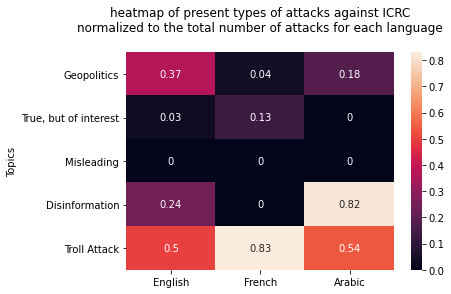

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df, annot=True)
plt.title('heatmap of present types of attacks against ICRC\nnormalized to the total number of attacks for each language\n')

plt.savefig('photos/heatmap_attacks_icrc.png', bbox_inches="tight")

* Generate final tweet based attacks

In [25]:
icrc_harmful_ar['language'] = 'ar'
icrc_harmful_fr['language'] = 'fr'
icrc_harmful_en['language'] = 'en'

icrc_harmful_tot = pd.concat(
    [icrc_harmful_ar, icrc_harmful_fr, icrc_harmful_en]
    )

icrc_harmful_tot

,tweet_id,publication_date,tweet,cluster_number,topic,Geopolitics,"True, but of interest",Misleading,Disinformation,Troll Attack,language
0,274571,2022-02-23,@adashtimp حرباء العرب تتلون بطبيعة السياسة ال...,13,ICRC not doing enough in Yemen,False,False,False,True,True,ar
1,272474,2022-02-24,@firasalsarrai تم تقاسمها وسرقتها من الوزارة (...,13,ICRC not doing enough in Yemen,False,False,False,True,True,ar
2,271943,2022-02-24,أمين عام الأمم المتحدة و الصليب الأحمر الدولي ...,13,ICRC not doing enough in Yemen,False,False,False,True,True,ar
3,229339,2022-02-25,@ICRC_ar اللجنة الدولية للاسف دورها في اليمن س...,13,ICRC not doing enough in Yemen,False,False,False,True,True,ar
4,212205,2022-02-25,@YahyaAlhadid @gulfidhr @USAbilAraby @FCDOArab...,13,ICRC not doing enough in Yemen,False,False,False,True,True,ar
...,...,...,...,...,...,...,...,...,...,...,...
411,1499830220895014912,2022-03-20,@SecBlinken @UNReliefChief @PMaurerICRC @UN @I...,89,Melania Trump related donation for Ukraine,True,False,False,False,False,en
412,1504868633759125504,2022-02-26,@MELANIATRUMP @ICRC Stuff it.. loser,89,Melania Trump related donation for Ukraine,True,False,False,False,False,en
413,1499737569424252928,2022-02-21,@ICRC Said the loser.,89,Melania Trump related donation for Ukraine,True,False,False,False,False,en
414,1489384392149676032,2022-02-24,@MELANIATRUMP @ICRC Loser,89,Melania Trump related donation for Ukraine,True,False,False,False,False,en


In [27]:
icrc_harmful_tot.to_csv('generated_data/final_icrc_hateful.csv', compression='gzip') 